In [32]:
import matplotlib.pyplot as plt
import numpy as np

In [33]:
from model import *
from data import *
from analysis import *

In [34]:
data0 = data[data["z_hw"] < 0.797]
data0 = data0[data0["ew_oiii_5007"] != 0]
len(data0)

19083

In [35]:
data1 = data0[data0["loglbol"] > 46]
len(data1)

1953

In [36]:
def for_oiii(ir = None):
    uppper = 0.797
    if ir:
        uppper = max(0, min(22 / ir - 1, 0.797))

    ret = data
    print(f"initial: {len(ret)}")
    ret = ret[ret["z_hw"] < uppper]
    ret = ret[ret["ew_oiii_5007"] != 0]
    print(f"select redshift: {len(ret)}")
    
    ret = ret[ret["loglbol"] > 46]
    print(f"select loglbol: {len(ret)}")


    ret = ret[
        np.apply_along_axis(all, 1, ret["WISE1234"] / ret["WISE1234_ERR"] > 3)
        ]
    print(f"select wise: {len(ret)}")
    return ret

In [37]:
_ = for_oiii()

initial: 105783
select redshift: 19083
select loglbol: 1953
select wise: 1891


In [38]:
oiii = for_oiii()
oiii_ = oiii[oiii["loglbol"] > 46]
oiii_res = np.loadtxt("../output/oiii.res")

initial: 105783
select redshift: 19083
select loglbol: 1953
select wise: 1891


In [174]:
oiii_res_slope = np.loadtxt("../output/oiii_slope.res")

In [39]:
len(oiii), len(oiii_)

(1891, 1891)

In [40]:
def analysis_(params_, up): # 1-up um
    optic, nir = components(params_)

    loglbol = np.log10(5 * optic(0.3))
    loglnirs = np.log10(nir(np.linspace(1,up)))
    logcfs = loglnirs - loglbol

    return logcfs

In [107]:
@np.vectorize
def disk_powlaw_slope(x, amp, slope):
    return amp * x ** slope


def components_slope(params_):
    *params, _, mod = params_
    dust_model = dust_models[int(mod)]

    disk_amp, dust_temp, dust_lbol, av, cold_dust, slope = params
    disk_amp = 10**disk_amp
    dust_lbol = 10**dust_lbol
    cold_dust = 10**cold_dust

    def optic(x):
        pl = disk_powlaw_slope(x, disk_amp, slope)
        return pl
    
    def nir(x):
        bb = blackbody(x, dust_temp, dust_lbol)
        cd = cold_dust * dust_model(x)
        return bb + cd
    
    return optic, nir

def analysis_slope(params_, up): # 1-up um


    optic, nir = components_slope(params_)

    loglbol = np.log10(5 * optic(0.3))
    loglnirs = np.log10(nir(np.linspace(1,up)))
    logcfs = loglnirs - loglbol

    return logcfs

In [110]:
oiii_res_slope[0]

array([ 4.52548486e+01,  1.44463458e+03,  4.54478686e+01, -6.01518457e-01,
        4.58011154e+01, -1.64415923e+00,  6.16671459e+00,  2.00000000e+00])

In [123]:
oiii_ans = np.array([analysis_(i, 12) for i in oiii_res])
oiii_loglbol = np.log10(5) + disk_powlaw(0.3, oiii_res_slope[:,0]) # disk_amp
oiii_cors = [parcor([np.log10(oiii_["ew_oiii_5007"]), oiii_ans[:,i], oiii_loglbol, oiii_["logbh_hb_vp06"]])[0,1]
for i in range(len(oiii_ans_[0,:]))]

In [175]:
oiii_ans_slope = np.array([analysis_slope(i, 12) for i in oiii_res_slope])
oiii_loglbol_slope = np.log10(5) + np.log10(disk_powlaw_slope(0.3, oiii_res_slope[:,0], oiii_res_slope[:,-3])) # disk_amp
oiii_cors_slope = [parcor([np.log10(oiii_["ew_oiii_5007"]), oiii_ans_slope[:,i], oiii_loglbol_slope, oiii_["logbh_hb_vp06"]])[0,1]
for i in range(len(oiii_ans_[0,:]))]

In [200]:
cond_radio = oiii_["R_6CM_2500A"] < 10
oiii_cors_no_radio = [parcor([np.log10(oiii_[cond_radio]["ew_oiii_5007"]), oiii_ans[cond_radio,i], oiii_loglbol[cond_radio], oiii_[cond_radio]["logbh_hb_vp06"]])[0,1]
for i in range(len(oiii_ans_[0,:]))]

cond_radio = oiii_["R_6CM_2500A"] >= 10
oiii_cors_radio = [parcor([np.log10(oiii_[cond_radio]["ew_oiii_5007"]), oiii_ans[cond_radio,i], oiii_loglbol[cond_radio], oiii_[cond_radio]["logbh_hb_vp06"]])[0,1]
for i in range(len(oiii_ans_[0,:]))]

In [194]:
oiii_cors = [parcor([np.log10(oiii_["ew_oiii_5007"]), oiii_ans[:,i], oiii_loglbol, oiii_["logbh_hb_vp06"]])[0,1]
for i in range(len(oiii_ans_[0,:]))]

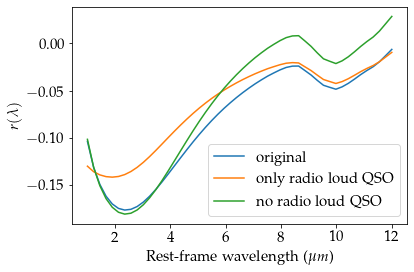

In [201]:
plt.plot(np.linspace(1,12), oiii_cors, label="original")

plt.plot(np.linspace(1,12), oiii_cors_radio, label="only radio loud QSO")
plt.plot(np.linspace(1,12), oiii_cors_no_radio, label="no radio loud QSO")
plt.legend()
plt.ylabel("$r(\lambda)$")
plt.xlabel("Rest-frame wavelength ($\mu m$)")


plt.savefig("/Users/wul/Desktop/radio.pdf", bbox_inches="tight")

In [157]:
cond_av = oiii_res[:,3] > 0
oiii_cors_low_av = [parcor(
    [ np.log10(oiii_[cond_av]["ew_oiii_5007"])
    , oiii_ans[cond_av][:,i]
    , oiii_loglbol[cond_av]
    , oiii_[cond_av]["logbh_hb_vp06"]
    ])[0,1]
for i in range(len(oiii_ans_[0,:]))]

In [143]:
def plot_with_err(x, y, err, ax=plt, linestyle=None, **kwargs):
    line, = ax.plot(x, y, linestyle=linestyle, **kwargs)
    error = ax.fill_between(x, y + err, y - err, **kwargs, alpha=0.2)
    return line, error

In [141]:
def single_bootstrap():
    ind = np.random.choice(np.arange(len(oiii_)), len(oiii_))

    return [parcor([np.log10(oiii_["ew_oiii_5007"][ind]), oiii_ans[ind,i], oiii_loglbol[ind], oiii_["logbh_hb_vp06"][ind]])[0,1]
for i in range(len(oiii_ans_[0,:]))]

def single_bootstrap_slope():
    ind = np.random.choice(np.arange(len(oiii_)), len(oiii_))

    return [parcor([np.log10(oiii_["ew_oiii_5007"][ind]), oiii_ans_slope[ind,i], oiii_loglbol_slope[ind], oiii_["logbh_hb_vp06"][ind]])[0,1]
for i in range(len(oiii_ans_[0,:]))]

In [176]:
def single_bootstrap_slope():
    oiii__ = oiii_[cond_av]
    oiii_ans_slope_ = oiii_ans_slope[cond_av]
    oiii_loglbol_slope_ = oiii_loglbol_slope[cond_av]
    l = len(oiii__)
    ind = np.random.choice(np.arange(l), l)

    return [parcor([np.log10(oiii__["ew_oiii_5007"][ind]), oiii_ans_slope_[ind,i], oiii_loglbol_slope_[ind], oiii_["logbh_hb_vp06"][ind]])[0,1]
for i in range(len(oiii_ans_[0,:]))]

In [165]:
def single_bootstrap_low_av():
    oiii__ = oiii_[cond_av]
    oiii_ans_ = oiii_ans[cond_av]
    oiii_loglbol_ = oiii_loglbol[cond_av]
    l = len(oiii__)
    ind = np.random.choice(np.arange(l), l)

    return [parcor(
    [ np.log10(oiii__["ew_oiii_5007"][ind])
    , oiii_ans_[ind,i]
    , oiii_loglbol_[ind]
    , oiii__["logbh_hb_vp06"][ind]
    ])[0,1]
for i in range(len(oiii_ans_[0,:]))]

In [159]:
cors_err = np.std([single_bootstrap() for i in range(100)], axis=0)
cors_slope_err = np.std([single_bootstrap_slope() for i in range(100)], axis=0)

KeyboardInterrupt: 

In [178]:
oiii_cors_slope = [parcor([np.log10(oiii_[cond_av]["ew_oiii_5007"]), oiii_ans_slope[cond_av,i], oiii_loglbol_slope[cond_av], oiii_[cond_av]["logbh_hb_vp06"]])[0,1]
for i in range(len(oiii_ans_[0,:]))]
cors_slope_err = np.std([single_bootstrap_slope() for i in range(100)], axis=0)

In [167]:
cors_low_av_err = np.std([single_bootstrap_low_av() for i in range(100)], axis=0)

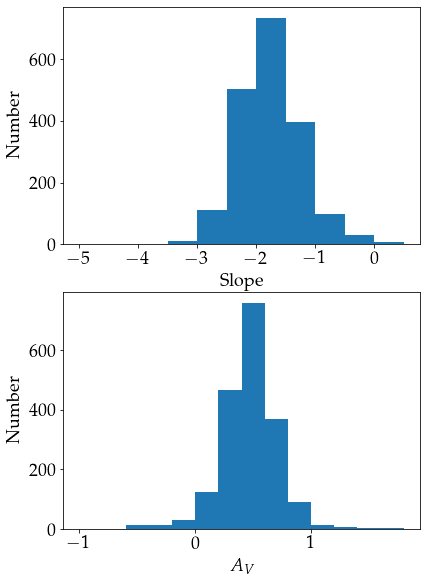

In [151]:
fig, axs = plt.subplots(2, 1, figsize=(6.4, 9.6))

axs[0].hist(oiii_res_slope[:, -3], bins=np.arange(-5,1, 0.5))
axs[0].set_xticks(np.arange(-5,1))

axs[0].set_xlabel("Slope")
axs[0].set_ylabel("Number")

axs[1].hist(-oiii_res_slope[:, 3], bins=np.arange(-1, 2, 0.2))

axs[1].set_xlabel("$A_V$")
axs[1].set_ylabel("Number")

plt.savefig("/Users/wul/Desktop/slope.pdf", bbox_inches="tight")

In [134]:
np.mean(oiii_res_slope[:, -4])

16.725276904538724

(array([  0.,   0.,  12.,  12.,  29., 123., 467., 757., 369.,  91.,  12.,
          8.,   2.,   3.]),
 array([-1.00000000e+00, -8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
        -2.00000000e-01, -2.22044605e-16,  2.00000000e-01,  4.00000000e-01,
         6.00000000e-01,  8.00000000e-01,  1.00000000e+00,  1.20000000e+00,
         1.40000000e+00,  1.60000000e+00,  1.80000000e+00]),
 <BarContainer object of 14 artists>)

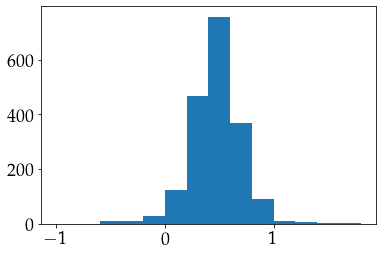

In [149]:
plt.hist(-oiii_res_slope[:, 3], bins=np.arange(-1, 2, 0.2))


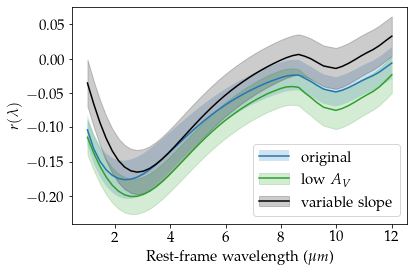

In [187]:
xx = np.linspace(1,12)
a = plot_with_err(xx, oiii_cors, cors_err)

b = plot_with_err(xx, oiii_cors_low_av, cors_low_av_err, color="tab:green")

c = plot_with_err(xx, oiii_cors_slope, cors_slope_err, color="black")

plt.legend([a, b, c], ["original", "low $A_V$", "variable slope"])

plt.xlabel("Rest-frame wavelength ($\mu m$)")
plt.ylabel("$r(\lambda)$")

plt.savefig("/Users/wul/Desktop/lowAV.pdf", bbox_inches="tight")

In [172]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 18
})

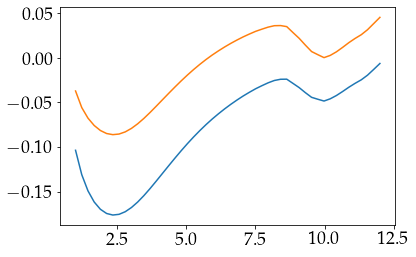

In [125]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors)
plt.plot(x, oiii_cors_slope)

In [42]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors)

corr_ = np.loadtxt("corr")

plt.plot(x, corr_)
plt.savefig("/Users/wul/Desktop/cors.png")

OSError: corr not found.

chi2, av, loglbol, logcf

In [185]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 15
})

In [427]:
np.corrcoef(extinction, logew)

array([[1.        , 0.09507294],
       [0.09507294, 1.        ]])

In [425]:
np.corrcoef(extinction, logcf)

array([[ 1.        , -0.29955415],
       [-0.29955415,  1.        ]])

(-2.0, 0.0)

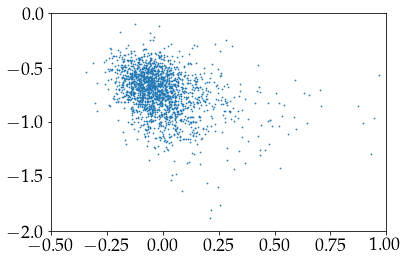

In [90]:
plt.scatter(extinction, logcf, s=0.5)
plt.xlim((-0.5, 1))
plt.ylim((-2,0))

In [93]:
cond_hb = oiii_["ew_broad_hb"] > 0
np.corrcoef(extinction[cond_hb], np.log10(oiii_[cond_hb]["ew_broad_hb"]))

array([[ 1.        , -0.11749011],
       [-0.11749011,  1.        ]])

In [95]:
cond_hb = oiii_["ew_narrow_hb"] > 0
np.corrcoef(extinction[cond_hb], np.log10(oiii_[cond_hb]["ew_narrow_hb"]))

array([[1.        , 0.08145975],
       [0.08145975, 1.        ]])

In [96]:
cond_ext = extinction < 0

In [100]:
np.corrcoef(logcf[cond_hb], np.log10(oiii_[cond_hb]["ew_broad_hb"]))

array([[1.        , 0.04171951],
       [0.04171951, 1.        ]])

In [99]:
np.corrcoef(logcf[cond_hb & cond_ext], np.log10(oiii_[cond_hb & cond_ext]["ew_broad_hb"]))

array([[ 1.        , -0.07778634],
       [-0.07778634,  1.        ]])

<ipython-input-91-adab725d1164>:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(extinction, np.log10(oiii_["ew_broad_hb"]), s=0.5)


(-0.5, 1.0)

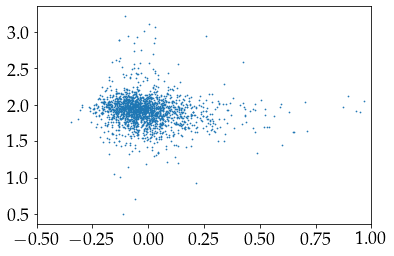

In [91]:
plt.scatter(extinction, np.log10(oiii_["ew_broad_hb"]), s=0.5)
plt.xlim((-0.5, 1))

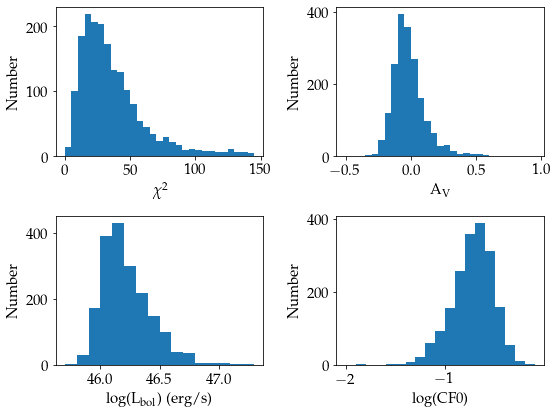

In [186]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
axs[0,0].hist(chi2, bins=np.arange(0, 150, 5))
axs[0,0].set_xlabel("$\chi^2$")
axs[0,0].set_ylabel("Number")

axs[0,1].hist(extinction, bins=np.arange(-0.5, 1, 0.05))
axs[0,1].set_xlabel("A$_\mathrm{V}$")
axs[0,1].set_ylabel("Number")

axs[1,0].hist(loglbol, bins=np.arange(45.7, 47.4, 0.1))
axs[1,0].set_xlabel("log(L$_\mathrm{bol}$) (erg/s)")
axs[1,0].set_ylabel("Number")

axs[1,1].hist(logcf, bins=np.arange(-2, 0, 0.1))
axs[1,1].set_xlabel("log(CF0)")
axs[1,1].set_ylabel("Number")

# plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()

plt.savefig("/Users/wul/Desktop/params.pdf")

In [44]:
loglbol = np.log10(5) + disk_powlaw_(np.log10(0.3)) + oiii_res[:,0]
logbh = oiii_["logbh"]
logew = np.log10(oiii_["ew_oiii_5007"])
dust_temp = oiii_res[:,1]
dust_loglbol = oiii_res[:,2]
extinction = -oiii_res[:,3]
cold_dust = oiii_res[:,4]

data = np.array([loglbol, logbh, logew, dust_temp, dust_loglbol, extinction, cold_dust])

(array([  4.,  33., 172., 390., 432., 298., 216., 149.,  98.,  41.,  34.,
          7.,   7.,   5.,   2.,   2.]),
 array([45.7, 45.8, 45.9, 46. , 46.1, 46.2, 46.3, 46.4, 46.5, 46.6, 46.7,
        46.8, 46.9, 47. , 47.1, 47.2, 47.3]),
 <BarContainer object of 16 artists>)

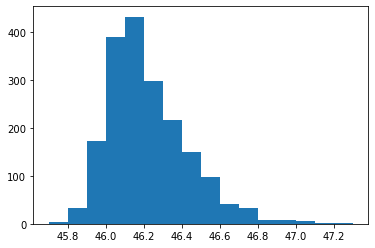

In [76]:
plt.hist(loglbol, bins=np.arange(45.7, 47.4, 0.1))

In [45]:
chi2 = oiii_res[:,5]

In [46]:
oiii_ans = np.array([analysis(i) for i in oiii_res])
logcf = oiii_ans[:, -1]

(array([  0.,   2.,   1.,   1.,   3.,   4.,   8.,  22.,  59.,  91., 158.,
        251., 348., 399., 317., 153.,  60.,   9.,   3.]),
 array([-2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. ,
        -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]),
 <BarContainer object of 19 artists>)

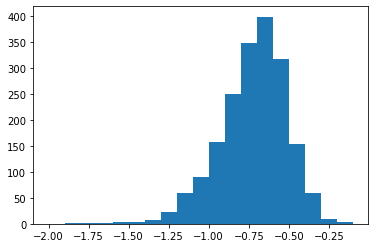

In [73]:
plt.hist(logcf, bins=np.arange(-2, 0, 0.1))

In [64]:
(extinction < 0).sum() / len(extinction)

0.6213643574828134

In [36]:
np.mean(extinction)

-0.004864174963381513

In [19]:
np.where((chi2 > 19.5) & (chi2 < 20.5) & (np.abs(dust_temp - 1500) > 0.1) & (extinction > 0.1))

(array([ 308,  388, 1467]),)

/Users/wul/Documents/Dust/src/model.py:191: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(hspace=0)


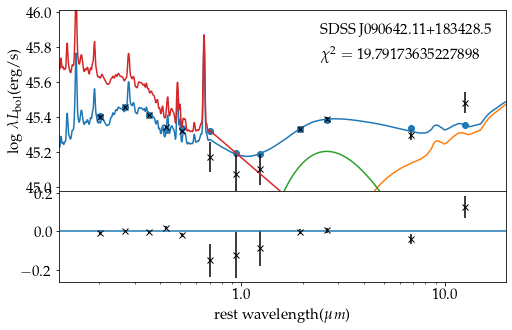

In [328]:
show_for_paper(oiii_[308], oiii_res[308])

In [47]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 18
})

In [94]:
oiii_[308]["sdss_name"]

'090642.11+183428.5'

In [48]:
from astropy.table import Table

In [49]:
tb = Table.read("/Users/wul/Desktop/Desktop_/out 5/090642.11+183428.5_best_model.fits")

In [50]:
from astropy.cosmology import Planck15

In [51]:
z = oiii_[308]["z_hw"]
zp1 = 1 + z
surf = 4 * np.pi * Planck15.luminosity_distance(z) ** 2

In [52]:
rsr, wavelength, lum, lum_unc = prepare_data(oiii_[308])
*params, residual, mod = oiii_res[308]
dust_model = dust_models[int(mod)]

In [53]:
c = 299792458 # m/s

In [54]:
xc_lum = (tb["Fnu"] * 1e23 * c / (tb["wavelength"] * 1e-9) * surf)
xc_torus = tb["agn.SKIRTOR2016_torus"] * tb["wavelength"] * 1e7
xc_polar = tb["agn.SKIRTOR2016_polar_dust"] * tb["wavelength"] * 1e7
xc_disk = tb["agn.SKIRTOR2016_disk"] * tb["wavelength"] * 1e7

In [55]:
ww = tb["wavelength"] / zp1
cond = (np.log10(ww * 1e-3) > np.log10(np.min(wavelength))-0.2) & (np.log10(ww * 1e-3) < np.log10(np.max(wavelength))+0.2)
xx = ww[cond] * 1e-3

In [343]:
len(bands)

11

In [345]:
len(wavelength)

12

(44.5, 46.0)

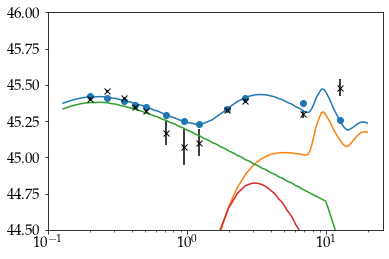

In [348]:
plt.plot(xx, np.log10(lum_m[cond].value))
plt.plot(xx, np.log10(lum_torus[cond]))
plt.plot(xx, np.log10(lum_disk[cond]))
plt.plot(xx, np.log10(lum_polar[cond]))
plt.errorbar(wavelength, lum, yerr=lum_unc, fmt='kx')
plt.scatter(wavelength, xc_bands)
plt.xscale("log")

plt.ylim((44.5, 46.))

In [56]:
from scipy.interpolate import interp1d

In [58]:
sed_x = interp1d(xx, xc_lum[cond].value, kind='cubic')
bands = np.log10([get_band(sed_x)(rsr, wav) for rsr, wav in zip(rsr, wavelength)])

In [59]:
sed = get_sed(dust_model, params)
x = np.logspace(np.log10(np.min(wavelength))-0.2, np.log10(np.max(wavelength))+0.2, 1000)

lum_ = np.log10(sed(x))
cold_dust = np.log10(dust_model(x)) + params[4]
hot_dust = np.log10(blackbody(x, params[1], 10**params[2]))
disk = np.log10(disk_powlaw(x, 10**params[0]))

bands = np.log10([get_band(sed)(rsr, wav) for rsr, wav in zip(rsr, wavelength)])

In [61]:
xc_lum = (tb["Fnu"] * 1e23 * c / (tb["wavelength"] * 1e-9) * surf)
xc_torus = tb["agn.SKIRTOR2016_torus"] * tb["wavelength"] * 1e7
xc_polar = tb["agn.SKIRTOR2016_polar_dust"] * tb["wavelength"] * 1e7
xc_disk = tb["agn.SKIRTOR2016_disk"] * tb["wavelength"] * 1e7

xc_sed = interp1d(xx, xc_lum[cond].value, kind='cubic')

ww = tb["wavelength"] / zp1
cond = (np.log10(ww * 1e-3) > np.log10(np.min(wavelength))-0.2) & (np.log10(ww * 1e-3) < np.log10(np.max(wavelength))+0.2)
xx = ww[cond] * 1e-3

xc_bands = np.log10([get_band(xc_sed)(rsr, wav) for rsr, wav in zip(rsr, wavelength)])

In [62]:
from scipy.interpolate import CubicSpline

In [63]:
sp_sed = CubicSpline(wavelength, 10**np.array(lum))

sp_bands = np.log10([get_band(sp_sed)(rsr, wav) for rsr, wav in zip(rsr, wavelength)])

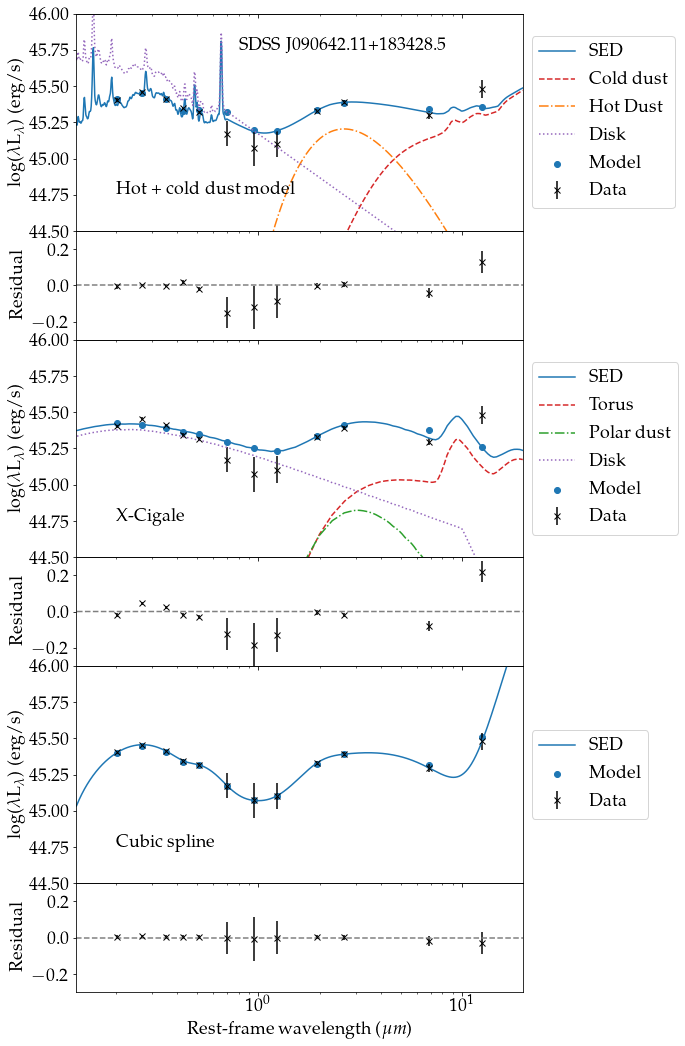

In [85]:
f, (a1, a2, ax1, ax2, as1, as2) = plt.subplots(6, 1, 
    gridspec_kw={'height_ratios': [2, 1, 2, 1, 2, 1]}, 
    sharex=True, figsize=(8, 18))


a1.text(0.8, 45.75, "SDSS J" + oiii_[308]['sdss_name'])
a1.text(0.2, 44.75, "Hot + cold dust model")

a1.plot(x, lum_, label="SED", c="tab:blue")
a1.plot(x, cold_dust, label="Cold dust", c="tab:red", linestyle="--")
a1.plot(x, hot_dust, label="Hot Dust", c="tab:orange", linestyle="-.")
a1.plot(x, disk, label="Disk", c="tab:purple", linestyle=":")

a1.errorbar(wavelength, lum, yerr=lum_unc, fmt="kx", label="Data")
a1.scatter(wavelength, bands, label="Model")

a2.errorbar(wavelength, lum - bands, yerr=lum_unc, fmt="kx")
a2.plot(x, np.zeros_like(x), c="tab:gray", linestyle="--")


a1.set_xscale('log')
a1.set_xlim((np.min(x), np.max(x)))
ylim = (44.5, 46)
a1.set_ylim(ylim)
ax1.set_ylim(ylim)
as1.set_ylim(ylim)

ax1.text(0.2, 44.75, "X-Cigale")

ax1.plot(xx, np.log10(xc_lum[cond].value), label="SED", c="tab:blue")
ax1.plot(xx, np.log10(xc_torus[cond]), label="Torus", c="tab:red", linestyle="--")
ax1.plot(xx, np.log10(xc_polar[cond]), label="Polar dust", c="tab:green", linestyle="-.")
ax1.plot(xx, np.log10(xc_disk[cond]), label="Disk", c="tab:purple", linestyle=":")

ax1.errorbar(wavelength, lum, yerr=lum_unc, fmt="kx", label="Data")
ax1.scatter(wavelength, xc_bands, label="Model")

ax2.errorbar(wavelength, lum - xc_bands, yerr=lum_unc, fmt="kx")
ax2.plot(xx, np.zeros_like(xx), c="tab:gray", linestyle="--")


as1.text(0.2, 44.75, "Cubic spline")

as1.plot(x, np.log10(sp_sed(x)), label="SED")

as1.errorbar(wavelength, lum, yerr=lum_unc, fmt="kx", label="Data")
as1.scatter(wavelength, sp_bands, label="Model")

as2.errorbar(wavelength, lum - sp_bands, yerr=lum_unc, fmt="kx")
as2.plot(x, np.zeros_like(x), c="tab:gray", linestyle="--")

a1.set_ylabel("log($\lambda$L$_\lambda$) (erg/s)")
ax1.set_ylabel("log($\lambda$L$_\lambda$) (erg/s)")
as1.set_ylabel("log($\lambda$L$_\lambda$) (erg/s)")

a2.set_ylabel("Residual")
ax2.set_ylabel("Residual")
as2.set_ylabel("Residual")

as2.set_xlabel("Rest-frame wavelength ($\mu m$)")


a1_ = a1.secondary_xaxis("top")
a1_.set_xticklabels([])
a1_.tick_params(axis="x", which="minor", direction="in")
a1_.tick_params(axis="x", which="major", direction="in")


ax1_ = ax1.secondary_xaxis("top")
ax1_.set_xticklabels([])
ax1_.tick_params(axis="x", which="minor", direction="in")
ax1_.tick_params(axis="x", which="major", direction="in")


as1_ = as1.secondary_xaxis("top")
as1_.set_xticklabels([])
as1_.tick_params(axis="x", which="minor", direction="in")
as1_.tick_params(axis="x", which="major", direction="in")

a2_ = a2.secondary_xaxis("top")
a2_.set_xticklabels([])
a2_.tick_params(axis="x", which="minor", direction="in")
a2_.tick_params(axis="x", which="major", direction="in")

ax2_ = ax2.secondary_xaxis("top")
ax2_.set_xticklabels([])
ax2_.tick_params(axis="x", which="minor", direction="in")
ax2_.tick_params(axis="x", which="major", direction="in")

as2_ = as2.secondary_xaxis("top")
as2_.set_xticklabels([])
as2_.tick_params(axis="x", which="minor", direction="in")
as2_.tick_params(axis="x", which="major", direction="in")

plt.subplots_adjust(hspace=0)

a1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
as1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

_lim = 0.3
a2.set_ylim((-_lim, _lim))
ax2.set_ylim((-_lim, _lim))
as2.set_ylim((-_lim, _lim))

plt.savefig("/Users/wul/Desktop/3fit.pdf", bbox_inches="tight")

In [ ]:
plt.scatter(av)

(array([115., 403., 411., 304., 232., 134.,  80.,  53.,  39.,  21.,  18.,
         14.,  19.,  12.,   8.,   6.,   0.,   1.,   2.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <BarContainer object of 19 artists>)

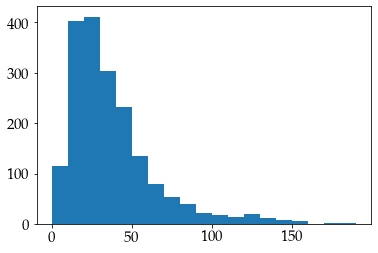

In [357]:
plt.hist(chi2, bins=np.arange(0, 200, 10))

In [362]:
result = Table.read("/Users/wul/Desktop/out 5/results.fits")

In [ ]:
xc_chi2 = 

In [261]:
cond_oiii = (oiii_res[:,3] > -0.5) & (oiii_res[:,-2] < 50)
oiii_ = oiii_[cond_oiii]
oiii_res = oiii_res[cond_oiii]

In [262]:
len(oiii_)

1456

In [272]:
result = Table.read("/Users/wul/Desktop/out 4/results.fits")

In [279]:
result = result[cond_oiii]

In [280]:
len(result)

1456

In [281]:
oiii_ans_x = []
for i in range(len(oiii_)):
    s = oiii_[i]
    zp1 = s["z_hw"] + 1
    tb = Table.read(f"/Users/wul/Desktop/out 4/{s['sdss_name']}_best_model.fits")
    wavelength = tb["wavelength"] * 1e-3 / zp1
    dust = tb["agn.SKIRTOR2016_dust"] * zp1
    func = interp1d(wavelength, dust, kind='cubic')
    oiii_ans_x.append(func(np.linspace(1, 12)) / result[i]['best.agn.luminosity'])

oiii_ans_x = np.array(oiii_ans_x)

In [282]:
oiii_cors_x = [parcor([np.log10(oiii_["ew_oiii_5007"]), np.log10(oiii_ans_x[:,i]), result['best.agn.luminosity'], oiii_["logbh_hb_vp06"]])[0,1]
for i in range(len(oiii_ans_x[0,:]))]

In [283]:
oiii_cors_x_ = [np.corrcoef([np.log10(oiii_["ew_oiii_5007"]), np.log10(oiii_ans_x[:,i])])[0,1]
for i in range(len(oiii_ans_x[0,:]))]

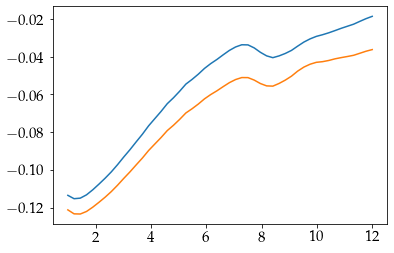

In [403]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors_x)
plt.plot(x, oiii_cors_x_)

In [406]:
def single_bootstrap_x():
    ind = np.random.choice(np.arange(len(oiii_ans_x)), len(oiii_ans_x))

    return [parcor([np.log10(oiii_["ew_oiii_5007"])[ind], np.log10(oiii_ans_x[:,i])[ind], result['best.agn.luminosity'][ind], oiii_["logbh_hb_vp06"][ind]])[0,1] for i in range(len(oiii_ans_x[0,:]))]

In [407]:
cors_std_x = np.std([single_bootstrap_x() for i in range(1000)], axis=0)

In [409]:
np.savetxt("cors_x", [oiii_cors_x, cors_std_x, oiii_cors_x_])

In [294]:
logbh = oiii_["logbh_hb_vp06"]
logbh[np.where(logbh == 0)] = oiii_[np.where(logbh == 0)]["logbh"]

In [295]:
oiii_ans_ = np.array([analysis_(i, 12) for i in oiii_res])
oiii_loglbol = np.log10(5) + disk_powlaw_(np.log10(0.3)) + oiii_res[:,0] # disk_amp
oiii_cors = [parcor([np.log10(oiii_["ew_oiii_5007"]), oiii_ans_[:,i], oiii_loglbol, logbh])[0,1]
for i in range(len(oiii_ans_[0,:]))]

oiii_cors_ = [np.corrcoef([np.log10(oiii_["ew_oiii_5007"]), oiii_ans_[:,i]])[0,1]
for i in range(len(oiii_ans_[0,:]))]

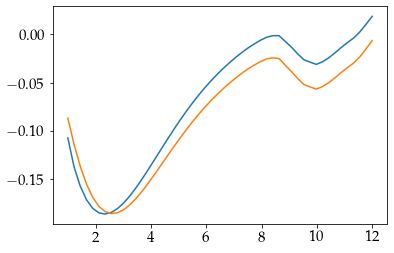

In [296]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors)
plt.plot(x, oiii_cors_)

In [101]:
def analysis_spline(i):
    s = oiii_[i]
    rsr, wavelength, lum, lum_unc = prepare_data(s)
    spline = CubicSpline(wavelength, lum)
    return [np.log10(spline(0.3)), np.log10(spline(np.linspace(1, 12))) - np.log10(spline(0.3))]

In [302]:
m = np.random.randn(1456)
n = np.random.randn(1456)
parcor([m, n, oiii_["loglbol"], oiii_["logbh_hb_vp06"]])[0,1]

0.008588543937411236

In [102]:
res_s = [analysis_spline(i) for i in range(len(oiii_))]

oiii_ans_s = np.array([r[1] for r in res_s])
loglbol_s = np.array([r[0] for r in res_s])
oiii_cors_s = [parcor([np.log10(oiii_["ew_oiii_5007"]), oiii_ans_s[:,i], loglbol_s, oiii_["logbh_hb_vp06"]])[0,1]
for i in range(50)]
oiii_cors_s_ = [np.corrcoef([np.log10(oiii_["ew_oiii_5007"]), oiii_ans_s[:,i]])[0,1]
for i in range(50)]

In [411]:
def single_bootstrap_s():
    ind = np.random.choice(np.arange(len(oiii_ans_x)), len(oiii_ans_x))

    return [parcor([np.log10(oiii_["ew_oiii_5007"])[ind], oiii_ans_s[:,i][ind], loglbol_s[ind], oiii_["logbh_hb_vp06"][ind]])[0,1]
for i in range(50)]

In [412]:
cors_std_s = np.std([single_bootstrap_s() for i in range(1000)], axis=0)

In [413]:
np.savetxt("cors_s", [oiii_cors_s, cors_std_s, oiii_cors_s_])

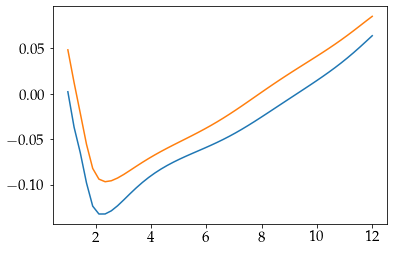

In [402]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors_s)
plt.plot(x, oiii_cors_s_)

In [104]:
x = np.linspace(1,12)
plt.plot(x[cond_hb & cond_ext], oiii_cors_s[cond_hb & cond_ext])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 50 but corresponding boolean dimension is 1891